# Case Study: Macaulay & Svensson, *Cell Reports* (2016)
Olga: print this paper for people to have

This "Case Study" is somewhat like a journal club except instead of just presenting the paper, we're going to re-work through some of these analyses ourselves and see how the interpretation of the data changes by using different algorithms

We will be using In this paper, co-authors Macaulay and Svensson studied haematopoesis in Zebrafish by doing...

* Clustered cells into groups (Figure 1)
* Ordered them by psuedotime (Figure 2)
* Showed expression of known (Figure 3) and novel (Figure 4) lineage markers
* Found a novel early committed group in the kidney before circulation in the blood (Figure 5)
* Identified genes that were differentially regulated over pseudotime (Figure 6)
* Investigated usage of duplicated genes during thrombopoeisis (Figure 7)

For the purposes of this case study

## Figure 1

<style type="text/css">
    ol { list-style-type: upper-alpha; }
</style>


**A.** In this study, the authors focused on "thrombocytes," which are the equivalent of megakaryotes in fish, and are marked by expression of CD41. TThey performed single-cell RNA-seq on FACS-sorted GFP+ cells from a CD41:EGFP transgenic fish, using the C1, aligning to the genome using STAR and used Salmon to quantify gene expression. <br>
**B.** They then performed ICA and did t-SNE on the ICA components! They're colored by whether this was a high or low GFP expressing cell.<br>
**C.** They then clustered the cells into groups by cutting a hierarchical clustering tree.

![Figure 1](figures/figure1.png)

Let's dig into this a little deeper. What if they did PCA instead of ICA? Or MDS instead of t-SNE? Or no previous filtering before t-SNE? How did they define their clusters?

Make a directory for saving the figures

In [1]:
mkdir figures

mkdir: figures: File exists


Load all Python libraries and the data.

In [19]:
# Must be the first import for compatibility reasons
from __future__ import print_function

# Alphabetical order of modules is convention
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import linalg
import seaborn as sns
from sklearn.decomposition import FastICA, PCA
from sklearn.manifold import TSNE, MDS

# Use plotting settings that I like
sns.set(style='white', context='talk')
%matplotlib inline


genes = pd.read_csv('macaulay2016/gene_expression_s.csv', index_col=0).sort_index(0).sort_index(1)
sample_data = pd.read_csv('macaulay2016/sample_info_qc.csv', index_col=0).sort_index(0).sort_index(1)

genes = genes.ix[:, sample_data[sample_data["Pass QC"]].index]
sample_data = sample_data[sample_data["Pass QC"]]
sample_data['condition_color'] = ['#31a354' if c == 'HIGH' else '#e5f5e0' for c in sample_data['condition']]


ercc_idx = filter(lambda i: 'ERCC' in i, genes.index)
egenes = genes.drop(ercc_idx)
egenes = egenes.drop('GFP')

egenes = (egenes / egenes.sum()) * 1e6

mask = (egenes > 1).sum(1) > 2
egenes = egenes.ix[mask]
original_expression_data = np.log10(egenes.T + 1).copy()

gene_annotation = pd.read_csv('macaulay2016/zv9_gene_annotation.txt', sep='\t', index_col=0)
gene_annotation = gene_annotation.ix[egenes.index]

Interactive function for trying dimensionality reduction and different components.

They said to pick their cutoff they used the frobenius norm reconstruction error, meaning, the difference between the ICA- or PCA-predicted matrix given the number of components, versus the original matrix, which we will plot as well. 

In [41]:
supplemental_data_sample_info = pd.read_csv('supplementary-data-1-sample-info/original_experiment_sample_info.csv', index_col=0)
supplemental_data_sample_info.head()

,% Parent,% Total,3'UTR_Exons,488,5'UTR_Exons,561,Average mapped length,CDS_Exons,Cells,ERCC Content,...,molecule_r2,outlier_component,total_molecules,within_large_component,within_small_component,cluster_color,tsne_0,tsne_1,log_488,log_SSC
Well,,,,,,,,,,,,,,,,,,,,,
DIM_1_A1,NaN,100.00%,615178,80.0,118167,6.0,229.53,1273306,1.0,116339.14620,...,0.849279,-0.119395,2884413.0,0.070390,-0.104144,"(0.55432528607985565, 0.62711267120697922, 0.7...",-0.357368,12.650468,1.903090,1.995635
DIM_1_A10,NaN,100.00%,625664,39.0,99645,1.0,230.31,1032911,1.0,279412.04190,...,0.853730,0.017293,794642.0,0.073285,0.020246,"(0.90311419262605563, 0.54185316071790801, 0.7...",-0.001426,6.763604,1.591065,1.579784
DIM_1_A11,NaN,100.00%,733798,53.0,245374,1.0,230.64,3031565,1.0,24324.44224,...,0.778746,-0.036702,9513110.0,-0.016871,-0.179175,"(0.55432528607985565, 0.62711267120697922, 0.7...",-8.698019,8.706809,1.724276,2.206826
DIM_1_A12,NaN,100.00%,827658,337.0,148061,9.0,230.22,1597099,1.0,186802.23200,...,0.901161,0.034679,1243023.0,0.045065,-0.065027,"(0.55432528607985565, 0.62711267120697922, 0.7...",-4.495216,11.184408,2.527630,2.068186
DIM_1_A2,NaN,100.00%,187244,83.0,38552,5.0,229.60,322876,1.0,251667.90200,...,0.817718,0.072677,902531.0,0.074522,0.049654,"(0.90311419262605563, 0.54185316071790801, 0.7...",-1.362267,3.037966,1.919078,1.892095


In [42]:
supplemental_data_sample_info['cluster_color'] = supplemental_data_sample_info['cluster_color'].map(eval)

In [43]:
supplemental_data_sample_info['cluster_color'][0]

(0.5543252860798557, 0.6271126712069792, 0.7959554139305564)

In [44]:
supplemental_data_sample_info.head()

,% Parent,% Total,3'UTR_Exons,488,5'UTR_Exons,561,Average mapped length,CDS_Exons,Cells,ERCC Content,...,molecule_r2,outlier_component,total_molecules,within_large_component,within_small_component,cluster_color,tsne_0,tsne_1,log_488,log_SSC
Well,,,,,,,,,,,,,,,,,,,,,
DIM_1_A1,NaN,100.00%,615178,80.0,118167,6.0,229.53,1273306,1.0,116339.14620,...,0.849279,-0.119395,2884413.0,0.070390,-0.104144,"(0.5543252860798557, 0.6271126712069792, 0.795...",-0.357368,12.650468,1.903090,1.995635
DIM_1_A10,NaN,100.00%,625664,39.0,99645,1.0,230.31,1032911,1.0,279412.04190,...,0.853730,0.017293,794642.0,0.073285,0.020246,"(0.9031141926260556, 0.541853160717908, 0.7649...",-0.001426,6.763604,1.591065,1.579784
DIM_1_A11,NaN,100.00%,733798,53.0,245374,1.0,230.64,3031565,1.0,24324.44224,...,0.778746,-0.036702,9513110.0,-0.016871,-0.179175,"(0.5543252860798557, 0.6271126712069792, 0.795...",-8.698019,8.706809,1.724276,2.206826
DIM_1_A12,NaN,100.00%,827658,337.0,148061,9.0,230.22,1597099,1.0,186802.23200,...,0.901161,0.034679,1243023.0,0.045065,-0.065027,"(0.5543252860798557, 0.6271126712069792, 0.795...",-4.495216,11.184408,2.527630,2.068186
DIM_1_A2,NaN,100.00%,187244,83.0,38552,5.0,229.60,322876,1.0,251667.90200,...,0.817718,0.072677,902531.0,0.074522,0.049654,"(0.9031141926260556, 0.541853160717908, 0.7649...",-1.362267,3.037966,1.919078,1.892095


In [45]:
original_expression_data.head()

0,ENSDARG00000000001,ENSDARG00000000002,ENSDARG00000000018,ENSDARG00000000019,ENSDARG00000000068,ENSDARG00000000069,ENSDARG00000000086,ENSDARG00000000102,ENSDARG00000000103,ENSDARG00000000142,...,ENSDARG00000098012,ENSDARG00000098017,ENSDARG00000098019,ENSDARG00000098021,ENSDARG00000098024,ENSDARG00000098027,ENSDARG00000098029,ENSDARG00000098031,ENSDARG00000098032,ENSDARG00000098040
Well,,,,,,,,,,,,,,,,,,,,,
DIM_1_A1,0.000000,0.0,1.850002,2.089687,0.0,2.045782,0.000000,0.0,0.721022,0.0,...,0.0,0.000000,0.0,0.0,1.427495,0.0,0.0,0.0,0.000000,1.334195
DIM_1_A10,0.000000,0.0,1.919964,0.000000,0.0,2.468288,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
DIM_1_A11,0.000000,0.0,1.700028,0.000000,0.0,1.681705,1.204102,0.0,0.421815,0.0,...,0.0,1.887484,0.0,0.0,1.668393,0.0,0.0,0.0,0.815419,0.498033
DIM_1_A12,2.131753,0.0,0.000000,1.820878,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
DIM_1_A2,0.000000,0.0,2.482449,0.000000,0.0,2.160210,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000


In [46]:
supplemental_data_sample_info.shape

(363, 49)

In [47]:
supplemental_data_sample_info = supplemental_data_sample_info.reindex(index=original_expression_data.index)
supplemental_data_sample_info.shape

(363, 49)

reconstruction norms: [ 1805.72763825  1805.72708446  1805.72653069  1805.7259769 ]


/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


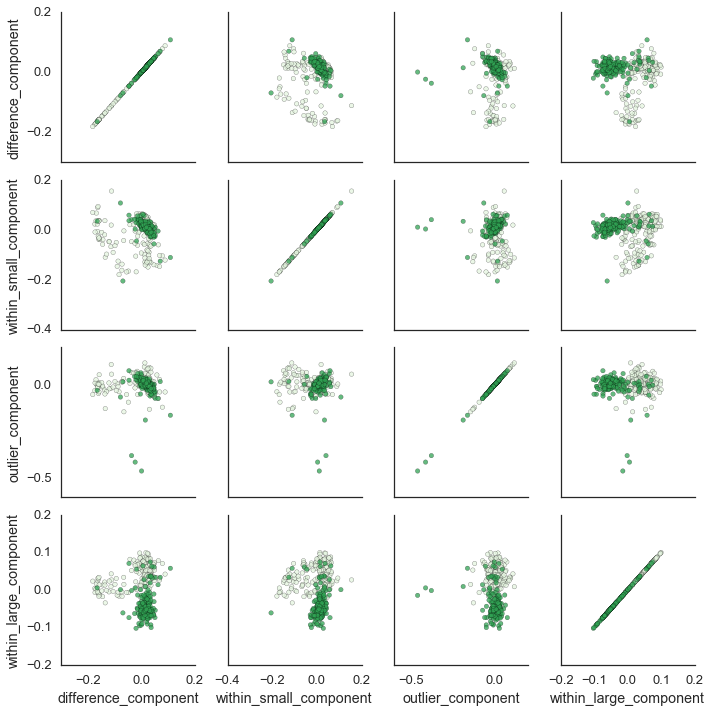

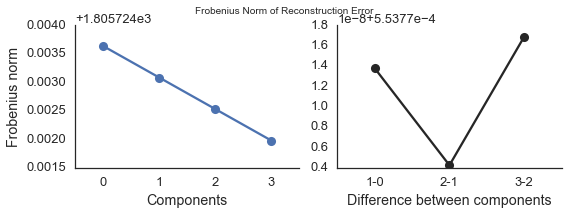

In [69]:
def explore_matrix_decomposition(algorithm, n_components, color_by):
    
    if algorithm == 'ICA':
        reducer = FastICA(n_components, random_state=3984)
    elif algorithm == 'PCA':
        reducer = PCA(n_components)

    Y = reducer.fit_transform(original_expression_data.copy())

    XX = pd.DataFrame(Y, index=egenes.columns)
    if n_components == 4 and algorithm == 'ICA':
        XX.columns = ['difference_component', 'within_small_component', 'outlier_component', 'within_large_component']

    if color_by == 'EGFP':
        color = sample_data['condition_color']
    elif color_by == 'Cluster assignment':
        color = supplemental_data_sample_info['cluster_color']
    
    g = sns.PairGrid(XX)
    g.map(plt.scatter, color=color, linewidths=0.25, edgecolors='k', alpha=0.75, s=20)

    # Reduce the number of ticks
    for ax in g.axes.flat:
        ax.locator_params(nbins=4)
    
    # --- Get how well this number of components reconstructs the original data --- #
    reconstruction_norms = []
    for i in range(1, n_components+1):
        reconstructed = pd.DataFrame(XX.values[:, :i].dot(reducer.components_[:i, :]), 
                                     index=original_expression_data.index, 
                                     columns=original_expression_data.columns)

        reconstruction_error = original_expression_data.subtract(reconstructed).abs()
        reconstruction_norms.append(np.linalg.norm(reconstruction_error))

    reconstruction_norms = np.array(reconstruction_norms)
    print('reconstruction norms:', reconstruction_norms)
    cumulative_difference = reconstruction_norms[:-1] - reconstruction_norms[1:]
    xticks = np.arange(n_components)
    
    fig, axes = plt.subplots(figsize=(8, 3), ncols=2)
    ax = axes[0]
    ax.plot(reconstruction_norms, 'o-')
    ax.set(xlabel='Components', ylabel='Frobenius norm', xticks=xticks, 
           xlim=(-0.5, n_components-0.5))
    
    ax = axes[1]
    plt.sca(ax)
    ax.plot(cumulative_difference, 'o-', color='#262626')  # #262626 = 90% black
    xticklabels = ['{}-{}'.format(i+1, i) for i in range(n_components-1)]
    ax.set(xticklabels=xticklabels, xlabel='Difference between components', xticks=xticks, 
           xlim=(-0.5, n_components-1.5))
    fig.suptitle("Frobenius Norm of Reconstruction Error")
    sns.despine()

ipywidgets.interact(explore_matrix_decomposition, 
                    algorithm=ipywidgets.Dropdown(options=['PCA', 'ICA'], value='ICA'), 
                    n_components=ipywidgets.IntSlider(value=4, min=2, max=10, step=1),
                    color_by=ipywidgets.Dropdown(options=['EGFP', 'Cluster assignment'], value='EGFP'));

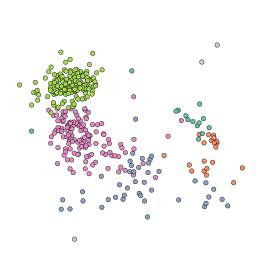

In [72]:
def explore_manifold_learning(matrix_decomposer, n_components, color_by, manifold_learner):
    if matrix_decomposer != "None":
        if matrix_decomposer == 'ICA':
            reducer = FastICA(n_components, random_state=3984)
        elif matrix_decomposer == 'PCA':
            reducer = PCA(n_components)

        decomposed = reducer.fit_transform(original_expression_data.copy())
        decomposed = pd.DataFrame(decomposed, index=egenes.columns)
    
        if n_components == 4 and algorithm == 'ICA':
            decomposed.columns = ['difference_component', 'within_small_component', 
                                  'outlier_component', 'within_large_component']
    else:
        decomposed == original_expression_data.copy()

    if manifold_learner == 't-SNE':
        embedder = TSNE(n_components=2, perplexity=75, random_state=254)
    elif manifold_learner == 'MDS':
        embedder = MDS(n_components=2, random_state=254)

    embedded = embedder.fit_transform(decomposed)
    embedded = pd.DataFrame(embedded, index=decomposed.index)

    fig, ax = plt.subplots(figsize=(4, 4))
    
    if color_by == 'EGFP':
        color = sample_data['condition_color']
    elif color_by == 'Cluster assignment':
        color = supplemental_data_sample_info['cluster_color']

    plt.scatter(embedded[0], embedded[1], c=color, s=20)
    # Empty the tick labels
    ax.set(xticks=[], yticks=[])
    sns.despine(bottom=True, left=True)
    fig.tight_layout()

ipywidgets.interact(explore_manifold_learning, 
                    matrix_decomposer=ipywidgets.Dropdown(options=['PCA', 'ICA', "None"], value='ICA'), 
                    n_components=ipywidgets.IntSlider(value=4, min=2, max=10, step=1),
                    color_by=ipywidgets.Dropdown(options=['EGFP', 'Cluster assignment'], value='EGFP'),
                    manifold_learner=ipywidgets.Dropdown(options=['t-SNE', 'MDS'], value='t-SNE'));

## Figure 2